# TP 3 Large Scale :

In [1]:
### IMPORTING ###
import scipy
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import svds
import math
from scipy.sparse.linalg import LinearOperator,bicg
import time
from tqdm.notebook import tqdm

## 1. X-ray tomography

## Q1 :

In [2]:
### DATA LOADING ###
H_data = scipy.io.loadmat('H.mat')
x_data = scipy.io.loadmat('x.mat')
H = H_data['H'] 
x = x_data['x'] 
M,N = H.shape

## Q2 :

In [3]:
### GENERATING OUR MEASUREMENTS ### 
y= H@x + np.random.normal(0,1,(16200,1))

### Q3 :

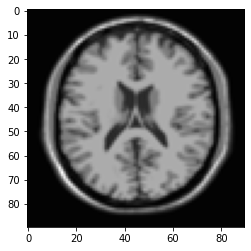

In [4]:
### PLOT OUR DATA ###
x_2D = x.reshape((90,90),order= 'F')
plt.imshow(x_2D, cmap = "gray")

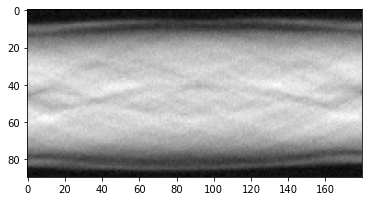

In [5]:
### PLOTING OUR MEASUREMENTS ###
y_2D = y.reshape((90,180),order= 'F')
plt.imshow(y_2D, cmap = "gray")

## 2. Optimization problem

## Q1 :

In [6]:
G_data = scipy.io.loadmat('G.mat')
G = G_data['G'] 
G.shape

(16200, 8100)

## Q2 :

The gradient of $f : x \mapsto ||Hx -y||^2_2 + \lambda \sum_{n=1}^{2N} \psi([ Gx ]^{(n)})$ has the following expression:

$$\nabla f = H^{T}(H x - y ) +\lambda G^{T}(\psi'([Gx]^n))_{1\geq n \geq 2N}$$

We introduce $r(x) = ||Hx -y||^2_2 $ then $\nabla r = H^{T}(H x - y )$.

We also have $\psi' : u \mapsto \frac{1}{\delta^2}\frac{u}{\sqrt{1+(\frac{u}{\delta})^2}}$.

In [12]:
### Parameters
delta= 0.02
lambd= 0.13

In [13]:
def phi_deriv(u,delta):
    i=u/((delta)**2)
    j=math.sqrt(1+(u/delta)**2)
    return i/j

In [14]:
def grad_r(x,delta):
    h=G@x
    for l in range(len(h)):
        h[l]=phi_deriv(h[l],delta)
    grad_r= (G.T)@h
    return grad_r

In [15]:
def gradient_f(x,lambd,delta):  # A function which gives as an output the gradient of f at some input vector x.
    grad_g= H.T@(H@x-y)
    grad_= grad_r(x,delta)
    return grad_g + lambd*grad_

In [16]:
gradient_f(x,lambd,delta).shape

(8100, 1)

## Q3 :

**We will calculate a Lipschitz constant L of $\nabla f$.**

Let $x_1$ and $x_2$ in $\mathbb{R}$,
we have $\nabla f (x_1) - \nabla f (x_2) = H^TH(x_1 - x_2) + \lambda G^T(\psi'([Gx_1]^n)-\psi'([Gx_2]^n) )_{1\geq n \geq 2N} $
<br><br> 
(i)For the left term, $||H^TH(x_1 - x_2)|| \leq ||H^TH||\times||x_1 - x_2||$ by definition of the norm of a matrix.
<br><br>
(ii)For the right term in the sum, $||G^T(\psi'([Gx_1]^n)-\psi'([Gx_2]^n) )_{1\geq n \geq 2N}|| \leq ||G^Tdiag(\psi''([Gx]^n)G||\times ||x_1 - x_2|| $. Here we used that for any differentiable function $f$, $\forall x, y, ||\nabla f(x)-\nabla f(y)|| \leq \max_{z \in \mathbb{R}^{2N}}||\nabla^2 f(z)||_{\mathcal{M}_{2N,2N}} ||x-y||$. 

We denote $\Delta  = diag(\psi''([Gx]^n)$, $G^T \Delta G$ is square, using the definition of the norm  $||G^T \Delta G|| = \sup_{x \in \mathbb{R}^N} \frac{x^TG^T \Delta Gx}{x^Tx}$ and as $x^TG^T \Delta Gx = \sum_{i=1}^{2N} \Delta_{ii} [Gx]_i^2 \leq \max_i\Delta_{ii}
\sum_{i=1}^{2N}  [Gx]_i^2 \leq (1/\delta^2)\sum_{i=1}^{2N}  [Gx]_i^2 =  (1/\delta^2) x^TG^T G x $

We obtain $||G^T(\psi'([Gx_1]^n)-\psi'([Gx_2]^n) )_{1\geq n \geq 2N}|| \leq (1/\delta^2)||G^TG||\times ||x_1 - x_2||$

<br><br>
$$\forall x_1, x_2~, ~~~~~~||\nabla f (x_1) - \nabla f (x_2)|| \leq (||H^T H||+\frac{\lambda}{\delta^2}||G^T G||)||x_1 - x_2|| $$



**We get that $L =(||H^T H||+\frac{\lambda}{\delta^2}||G^T G||)$ is a Lipschitz constant of $\nabla f$.**

In [17]:
j=max(scipy.sparse.linalg.svds(H)[1])
k=max(scipy.sparse.linalg.svds(G)[1])
L = j**2 + (0.13/((0.02)**2))*(k**2)
print("Our Lipschitz constant is L =", L)

Our Lipschitz constant is L = 18092.773276864777


## 3. Optimization Algorithms :

### 3.1 Gradient descent algorithm :

In [18]:
def normalized_quadratic_error(h):  # We define here the normalized_quadratic_error function which will                      
    e=(np.linalg.norm(h-x))**2      # allow us to quantify the performance of the different
    e0=(np.linalg.norm(x))**2       # techniques we will implement.
    E=e/e0
    return E

In [19]:
def plot_recovered_data(h):              # Function that will display the retrieved data and
    h_2D = h.reshape((90,90),order= 'F') # visually report on the performance of the method.
    plt.imshow(h_2D, cmap = "gray")

### Q1 :

In [20]:
x0=np.zeros((8100,1))

### Q2 :

In [21]:
def gradient_descent(x0,n_iter,lambd,delta): # Gradient descent algorithm to minimize f.
    xn=x0    
    for n in range (n_iter):
        xn = xn + (-1/L)*gradient_f(xn,lambd,delta)
    return xn

In [22]:
### PARAMETERS ###
n_iter=50

#lr=-1/L

In [23]:
h=gradient_descent(x0,n_iter,lambd,delta)


In [24]:
print("The normalized quadratic error using gradient descent algorithm is",normalized_quadratic_error(h),'.')

The normalized quadratic error using gradient descent algorithm is 0.027196724024351315 .


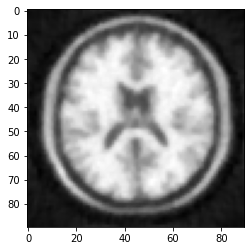

In [25]:
plot_recovered_data(h)

### 3.2 MM quadratic algorithm :

### Q1 :

In [26]:
def g(x):
    return 1/2*((H@x-y).T)@(H@x-y)

In [27]:
def phi(x,delta):
    return math.sqrt(1+(x/delta)**2)

In [28]:
def r(x,delta):
    h=G@x
    for l in range(len(h)):
        h[l]=phi(h[l],delta)
    return h

In [29]:
def curvature(x0,lambd,delta): # the curvature A(x) of the majorant function at an input vector x.
    B=G@x0
    for k in range(len(B)) :
        B[k]=1/((delta)**2)*(1/phi(B[k],delta))
    B=scipy.sparse.diags(B.T[0]).tocsc()
    B= (G.T)@B@G
    curv= (H.T)@H + lambd*B
    return LinearOperator((8100,8100), matvec=(lambda x : curv@x), rmatvec = (lambda x : curv@x))                                           #LinearOperator((8100,8100), matvec=curv, rmatvec=curv)

### Q2 :

In [30]:
def MM(x0,n_iter,lambd,delta): # MM quadratic algorithm to minimize f.
    tic = time.perf_counter()
    xn=x0
    for k in range(n_iter):
        A=curvature(xn,lambd,delta)
        xn = xn - scipy.sparse.linalg.bicg(A,gradient_f(xn,lambd,delta))[0].reshape(8100,1)
    toc = time.perf_counter()
    #print(f"Time of MM : {toc - tic:0.4f} seconds")
    return xn

In [31]:
h=MM(x0,15,lambd,delta)

In [32]:
print("The normalized quadratic error using Majorization-Minimization quadratic algorithm is", normalized_quadratic_error(h))

The normalized quadratic error using Majorization-Minimization quadratic algorithm is 0.01255332355314217


The square error is very satisfactory.

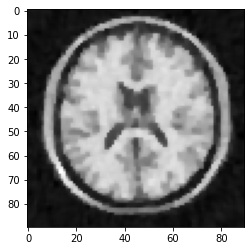

In [33]:
plot_recovered_data(h)

We find an image close to the original image.

### 3.3 3MG algorithm :

### Q1 :

In [34]:
def PAD(x,D,lambd,delta):
    A=curvature(x,lambd,delta)
    return A*D

In [35]:
def F3MG(x0,n_iter,lambd,delta):
    tic = time.perf_counter()
    xn=x0                        # Convention x-1=0
    xn1=x0
    for k in range(n_iter):
        g1=gradient_f(xn1,lambd,delta)
        Dk=(np.array([g1,xn1-xn]).T)[0]
        c= scipy.linalg.pinv(Dk.T@(PAD(xn1,Dk,lambd,delta)))
        d= (Dk.T)@g1
        uk=-c@d
        xn=xn1
        xn1= xn1 + Dk@uk
    toc = time.perf_counter()
    #print(f"Time of 3MG : {toc - tic:0.4f} seconds")
    return xn1

In [36]:
h=F3MG(x0,15,lambd,delta)

In [37]:
print("The normalized quadratic error using 3MG algorithm is",normalized_quadratic_error(h))

The normalized quadratic error using 3MG algorithm is 0.010633878981229762


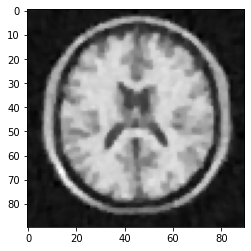

In [38]:
plot_recovered_data(h)

147 seconds for the MM algorithm and 56 seconds for the 3MG scheme : 3 times quicker with similar performances.

### 3.4 Block-coordinate MM quadratic algorithm :

### Q1 :

In [39]:
def Aj(x,j,J,lambd,delta):
    Nj=len(x)//J
    B=G@x
    for k in range(len(B)) :
        B[k]=1/((delta)**2)*(1/phi(B[k],delta))
    B=scipy.sparse.diags(B.T[0]).tocsc()
    Gj=((G.T)[(j-1)*Nj:j*Nj]).T
    Hj=((H.T)[(j-1)*Nj:j*Nj]).T
    B= (Gj.T)@B@Gj
    curv= (Hj.T)@(Hj) + lambd*B
    return curv

### Q2 :

In [66]:
def BCMM(x0,n_iter,J,lambd,delta):
    tic = time.perf_counter()
    x=x0
    Nj=len(x0)//J
    for k in range(1,n_iter) :
        j = (k-1)%J +1
        v = x[(j-1)*Nj:j*Nj]
        v = v - scipy.sparse.linalg.inv(scipy.sparse.csr_matrix(Aj(x,j,J,lambd,delta)))@(gradient_f(x,lambd,delta)[(j-1)*Nj:j*Nj])
        x[(j-1)*Nj:j*Nj] = v
    toc = time.perf_counter()
    #print(f"Time of BCMM : {toc - tic:0.4f} seconds")
    return x

In [67]:
h=BCMM(x0,54,9,lambd,delta)

In [42]:
#h=BCMM(x0,24,6)

In [43]:
#h=BCMM(x0,20,5)

In [44]:
#h=BCMM(x0,12,3)

In [45]:
#h=BCMM(x0,8,2)

Quicker with similar performances with J high but with J low, the computation time is very high and the normalized quadratic error very high. (Make sense because for a low J we loose the advantage of the method but have higher computation costs). When J inscrease : error decrease.

In [68]:
print("The normalized quadratic error using Block-coordinate MM quadratic algorithm is",normalized_quadratic_error(h))

The normalized quadratic error using Block-coordinate MM quadratic algorithm is 0.012632074263014128


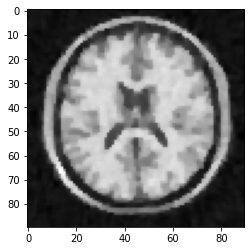

In [69]:
plot_recovered_data(h)

### 3.5 Parallel MM quadratic algorithm

### Q1 :

**We have to prove that $A(x) \preceq  B(x)$ for every real $x$.**

**1) We will prove an useful inequality.**

Let $x_1, c_1\dots, x_P,c_p$ be real numbers and $w_1,\dots , w_P >0$ such that $w_1+ \dots + w_P = 1$.

We denote $y_p = \frac{c_p x_p}{w_p}$ for $p \in \{1,\dots,P\}$.

Let denote $g:\mathbb{R} \rightarrow \mathbb{R}$ a convex function. 

$w_1,\dots, w_P$ verify $\sum_p w_p = 1$, we can apply Jensen's inequality. We get:
$$g\left(\sum_p w_p y_p\right)\leq \sum_p w_p g\left(y_p \right)$$

This proves the following inequality (1) for any convex function $g$:
$$g\left(\sum_p c_p x_p \right)\leq \sum_p w_p g\left(\frac{c_p x_p}{w_p} \right) ~~~~~~~~~~~\text{(1)}$$

<br><br>

**2) We will find a majorant for $x^T H^T Hx$**

$[Hx]_m = \sum H_{m,i}x_i$, we can apply inequality (1) with $g:u \mapsto u^2$. We obtain $g([Hx]_m) \leq \sum_{i=1}^M \frac{H_{m,i}^2}{w_i}x_i^2 $. We notice that $\sum_{i=1}^M g([Hx]_m) = ||Hx||_2^2 = x^T H^THx  $. 

If we choose $w_i = |H_{m,i}|/ \left( \sum_{j=1}^N |H_{m,j}|\right)$ ,  the right-hand side of the inequality becomes $\sum_{i=1}^M |H_{m,i}|x_i^2 \left( \sum_{j=1}^N |H_{m,j}|\right) := \alpha^{(m)}$. Now we will compute $x^T diag(\mathcal{H_i}^T1)_i x$ where $\mathcal{H_i} = (\mathcal{H_i}^m)$ and $\mathcal{H_i}^m=|H_{m,i}|\sum_{p=1}^N|H_{m,p}|$.
$$x^T diag(\mathcal{H_i}^T1)_i x = \sum_i x_i^2 \mathcal{H_i}^T1 = \sum_i x_i^2 \sum_m \mathcal{H_i}^m = \sum_i x_i^2 \sum_m |H_{m,i}|\sum_{p=1}^N |H_{m,p}| = \sum_m \alpha^{(m)} $$

We have : $\forall x, x^TH^THx \leq x^T diag(\mathcal{H_i}^T1)x$

**We proved $H^TH \preceq diag(\mathcal{H}^T1) $**

<br><br>

**3)We will find a majorant to $\lambda G^T diag\left(w([Gx]_n)\right) G$**



$x^TG^T diag\left(w([Gx]_n)\right) Gx = \sum_{i=1}^n w([Gx]_i) [Gx]_i^2 = \sum_{i=1}^N g_i([Gx]_i)$ where $g_i : u \mapsto w([Gx]_i) u^2$

<br>

$g_1,\dots, g_N$ are convex. Using inequality (1), $ g_i(\sum_k G_{i,k}x_k)\leq \sum_k c_k g_i( G_{i,k}x_k/c_k)= \sum_k w([Gx]_i)  G_{i,k}^2x_k^2/c_k$. By choosing $c_k = |G_{m,k}|/ \left( \sum_{j=1}^N |H_{m,j}| \right)$, we have  $ g_i\left(\sum_k G_{i,k}x_k \right)\leq \sum_k w([Gx]_i)  |G_{i,k}|x_k^2 \left( \sum_{j=1}^N |G_{m,j}| \right) := \beta^{(i)}$.

<br>
We remind that $w$ is the following function $w : u \mapsto (1/\delta^2) \frac{1}{\sqrt{1+(u/\delta)^2}}$, so $w(u) = \frac{\psi'(u)}{u}$.

To conclude we have that $$\sum_i\beta^{(i)} = x^T diag\left(\mathcal{G_i}^T\left( \frac{\dot{\psi}(Gx)}{Gx} \right)\right)x $$.


**We proved $G^T diag(w[Gx])G\preceq diag\left( \mathcal{G_i}^T \left(\frac{\dot{\psi}(Gx)}{Gx}\right) \right) $**


<br><br>

$$\boxed{  H^TH  +\lambda G^T diag(w[Gx])G\preceq diag(\mathcal{H}^T1)+ \lambda~ diag\left( \mathcal{G_i}^T \left(\frac{\dot{\psi}(Gx)}{Gx}\right) \right)}$$

### Q2 :

In [76]:
def B(x0,lambd,delta):
    K=G@x0
    for k in range(len(K)) :
        K[k]=1/((delta)**2)*(1/phi(K[k],delta))
    E=np.ones((8100,1))
    C=(((np.abs(G))@E)) 
    D=np.diag(C@(K.T))
    D=np.array([D]).T
    Gi=((np.abs(G).T))@(D)
    Hi= (np.abs(H).T)@(((np.abs(H))@E))
    B= Hi + lambd*Gi
    B=scipy.sparse.diags(B.T[0]).tocsc()
    return LinearOperator((8100,8100), matvec=(lambda x : B@x), rmatvec = (lambda x : B@x))

In [77]:
def PMM(x0,n_iter,lambd,delta):
    tic = time.perf_counter()
    xn=x0
    for k in range(n_iter):
        A=B(xn,lambd,delta)
        xn = xn - scipy.sparse.linalg.bicg(A,gradient_f(xn,lambd,delta))[0].reshape(8100,1)
    toc = time.perf_counter()
    #print(f"Time of PMM : {toc - tic:0.4f} seconds")
    return xn

In [78]:
h= PMM(x0,30,lambd,delta)

In [79]:
print("The normalized quadratic error using Parallel MM quadratic algorithm is",normalized_quadratic_error(h))

The normalized quadratic error using Parallel MM quadratic algorithm is 0.012635401377105037


we get a good result more quickly but the performances are less good than for the other algorithms.

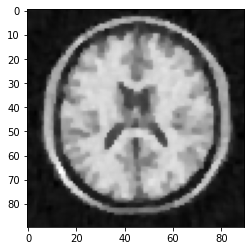

In [80]:
plot_recovered_data(h)

Note: the optimal parameters of the methods depend on the randomly generated data at the beginning of the notebook.

### 3.6 Comparison of the methods

### Q1 :

In [81]:
def criterion(x):
    f=0.5*(np.linalg.norm(H@x-y)**2) + 0.13*np.sum(r(x,delta))
    return f

In [82]:
criterion(x0)

12807.846558652745

In [94]:
def criterion_algorithm(method,n_iter,lambd,delta): # Function that takes as input the method used and the number of iterations.
    l=[]
    x=np.zeros((8100,1))
    l.append(criterion(x))
    for k in range(n_iter):
        if method==BCMM :
            x=method(x,9,9,lambd,delta)          # For the BCMM method, it is interesting especially when you have done a cycle.
            l.append(criterion(x))
        else :
            x=method(x,1,lambd,delta)
            l.append(criterion(x))
    return l                         # We return the list of all the values taken by f during the iterations.

In [96]:
criterion_algorithm(BCMM,3,lambd,delta)

[6835669.501387931, 1899733.5849953217, 177126.463836478, 68643.21553379667]

### Q2 :

In [ ]:
def criterion_algorithm1(method,lambd,delta): # Function that takes as input the method used and stops when the condition 
    l=[]                          # is verified. 
    tic = time.perf_counter()
    x=np.zeros((8100,1))
    l.append([criterion(x),0])
    c=np.linalg.norm(gradient_f(x,lambd,delta))
    while c > len(x)*(1.e-1):                # Condition d'arrêt, que l'on réduit sinon cela prend trop de temps
        if method==BCMM :                    # à converger. It returns the execution time.
            x=method(x,9,9,lambd,delta)
            toc = time.perf_counter()
            l.append([criterion(x),toc-tic])
        else :
            x=method(x,1,lambd,delta)
            toc = time.perf_counter()
            l.append([criterion(x),toc-tic])
        c= np.linalg.norm(gradient_f(x,lambd,delta))
    toc = time.perf_counter()
    print(f"Time of the method {method} : {toc - tic:0.4f} seconds")
    fig=plt.figure(1,(10,6))
    plt.yscale("log")
    x=[l[i][1] for i in range(len(l))]
    y=[l[i][0] for i in range(len(l))]
    plt.plot(x, y)
    
    plt.xlabel("Time (in seconds)")
    plt.ylabel("f the criterion function")
    plt.title('Evolution of the function criterion over time')
    plt.grid(True)
    plt.show()
    #return l

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Time of the method <function F3MG at 0x000001D4B224A0D0> : 285.0430 seconds


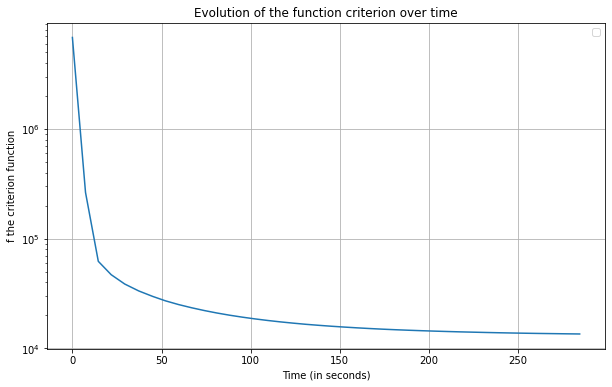

In [105]:
l=criterion_algorithm1(F3MG,lambd,delta)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Time of the method <function MM at 0x000001D4B22441F0> : 27.6312 seconds


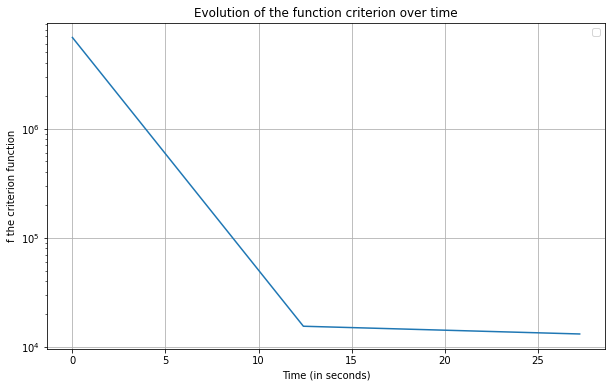

In [107]:
l=criterion_algorithm1(MM,lambd,delta)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Time of the method <function PMM at 0x000001D4B1D41EE0> : 161.0592 seconds


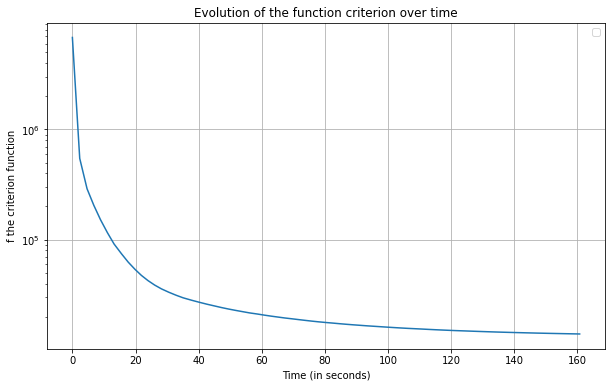

In [108]:
l=criterion_algorithm1(PMM,lambd,delta)

In [ ]:
l=criterion_algorithm1(BCMM,lambd,delta)

In [ ]:
l=criterion_algorithm1(gradient_descent,lambd,delta)

We had to modify the stop condition to make it more flexible: indeed, except for simple methods like MM or grandient_descent, it takes a long time to check this condition. Maybe there is a problem in the implementation of our methods. Nevertheless, even if they seem to be less efficient with this criterion, we have seen above that these methods are very efficient in terms of their convergence speed to obtain a low normalized quadratic error.

### Q3 :

Surprisingly according to the convergence criterion of the loop, the convergence is the fastest for the MM algorithm.
Nevertheless, as we have seen in the previous sections, to obtain the best squared error in a given minimum time, there are more efficient methods. In particular the 3MG algorithm. Indeed in this part the objective is to maximize the SNR which means minimizing the squared error. To determine the optimal values of $\lambda$ and $\delta$ we will use the 3MG algorithm.

In [110]:
def snr(h):   # The goal is going to be to maximize the SNR.
    e=(np.linalg.norm(h-x))**2
    e0=(np.linalg.norm(h))**2
    return 10*math.log10((e0/e))

To simplify the search, we assume that determining the best lambda does not depend on delta and vice versa. We start by determining the best lambda.
Then we will determine the best delta.

In [111]:
lambdas =  [0.05+ i*1e-2 for i in range(18)] 

In [112]:
def find_best_lambda(lambdas,delta):
    best_SNR = 0 
    best_lambda = lambdas[0]
    SNR = []
    
    for i,lambd in enumerate(tqdm(lambdas)):
        a= F3MG(x0,15,lambd,delta)
        S = snr(a)
        SNR.append(S)
        if S > best_SNR:
            best_SNR = S
            best_lambda = lambd
            
    plt.plot(lambdas, SNR)
    plt.title("SNR evolution depending on lambdas")
    plt.xlabel("lambdas")
    plt.ylabel("SNR")
    plt.show()
            
    print("Best lambda: ", best_lambda)

  0%|          | 0/18 [00:00<?, ?it/s]

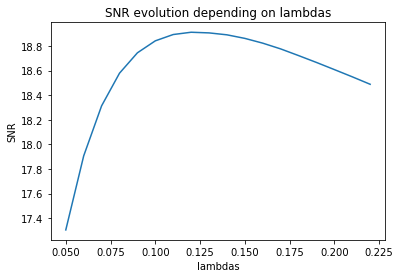

Best lambda:  0.12000000000000001


In [113]:
find_best_lambda(lambdas,0.02)

We obtain that the value of $\lambda$ which optimizes the SNR is $\lambda=0.11$

In [114]:
deltas =  [i*1e-2 for i in range(1,15)]

In [115]:
def find_best_deltas(deltas,lambd):
    best_SNR = 0 
    best_deltas = deltas[0]
    SNR = []
    
    for i, delta in enumerate(tqdm(deltas)):
        a= F3MG(x0,15,lambd,delta)
        S = snr(a)
        SNR.append(S)
        if S > best_SNR:
            best_SNR = S
            best_deltas = delta
            
    plt.plot(deltas, SNR)
    plt.title("SNR evolution depending on deltas")
    plt.xlabel("deltas")
    plt.ylabel("SNR")
    plt.legend()
    plt.show()
            
    print("Best delta: ", best_deltas)

  0%|          | 0/14 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


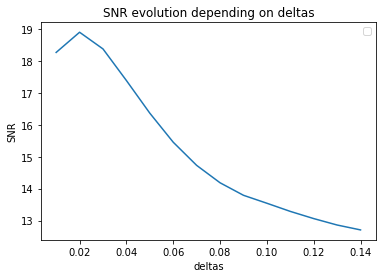

Best delta:  0.02


In [117]:
find_best_deltas(deltas,0.11)

We obtain that the value of $\delta$ which optimizes the SNR is $\delta= 0.03$
We conclude that the parameters ($\lambda$,$\delta)$$=(0.11,0.03)$ optimize the SNR.

In [1]:
! jupyter nbconvert --to html C:\Users\marce\Documents\Cours\Large_Scale_and_Ditributed_computing\TP_3_Large_Scale.ipynb

[NbConvertApp] Converting notebook C:\Users\marce\Documents\Cours\Large_Scale_and_Ditributed_computing\TP_3_Large_Scale.ipynb to html
[NbConvertApp] Writing 1187916 bytes to C:\Users\marce\Documents\Cours\Large_Scale_and_Ditributed_computing\TP_3_Large_Scale.html
